# Multimodal Fake News Detection - Example Usage

This notebook demonstrates how to use the multimodal fake news detection pipeline.

In [1]:
import sys
sys.path.append('..')

import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer

from src.data.dataset import MultimodalDataset
from src.data.transforms import get_image_transforms


## 1. Load Dataset

In [22]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create dataset
dataset = MultimodalDataset(
    csv_file='../data/multimodal_validate5000.csv',  # Update path
    root_dir='../data/images/validate/',       # Update path
    tokenizer=tokenizer,
    max_length=128,
    image_transform=get_image_transforms(mode='train'),# val
    text_column='text_content',
    image_column='image_path',
    label_column='label'
)

print(f"Dataset size: {len(dataset)}")
print(f"Class distribution: {dataset.get_class_distribution()}")

Dataset size: 3356
Class distribution: {1: 1843, 0: 1513}


## 2. Visualize Sample

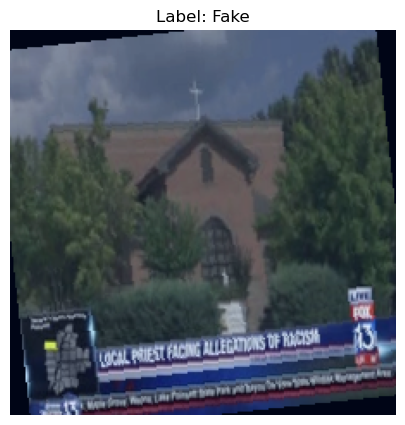


Text: collierville priest would not allow black woman to clean church, blames his dog


In [23]:
from src.models.multimodal_net import MultimodalNet
from src.utils.metrics import calculate_metrics

import matplotlib.pyplot as plt
import numpy as np

# Get a sample
sample = dataset[0]

# Display image
image = sample['image'].permute(1, 2, 0).numpy()
image = (image - image.min()) / (image.max() - image.min())

plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.title(f"Label: {'Fake' if sample['label'] == 1 else 'Real'}")
plt.axis('off')
plt.show()

# Display text
text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
print(f"\nText: {text}")

## 3. Initialize Model

In [24]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MultimodalNet(
    embedding_dim=512,
    fusion_hidden_dim=256,
    dropout_rate=0.4
).to(device)

# Print model info
param_counts = model.count_parameters()
print(f"\nTotal parameters: {param_counts['total']:,}")
print(f"Trainable parameters: {param_counts['trainable']:,}")

Using device: cpu


c:\Users\admin\miniconda3\envs\ml-zoomcamp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\admin\miniconda3\envs\ml-zoomcamp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Total parameters: 72,240,765
Trainable parameters: 72,240,765


## 4. Test Forward Pass

In [25]:
# Create a batch
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)
batch = next(iter(dataloader))

# Move to device
batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

# Forward pass
model.eval()
with torch.no_grad():
    outputs = model(batch)

print(f"\nOutput shape: {outputs.shape}")
print(f"Predictions (first 5): {outputs[:5].squeeze().cpu().numpy()}")


Output shape: torch.Size([8, 1])
Predictions (first 5): [0.5236275  0.5213476  0.5224052  0.5206931  0.52255124]


## 5. Load Trained Model (Optional)

In [19]:
# Load checkpoint
checkpoint_path = '../checkpoints/best_model.pth'

try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    print(f"Validation accuracy: {checkpoint['val_accuracy']:.4f}")
except FileNotFoundError:
    print(f"Checkpoint not found at {checkpoint_path}")
    print("Train the model first!")

Checkpoint not found at ../checkpoints/best_model.pth
Train the model first!


## 6. Inference and Evaluation

In [28]:
# Run inference on validation set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in dataloader:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v 
                for k, v in batch.items()}
        
        outputs = model(batch)
        all_predictions.append(outputs.cpu())
        all_labels.append(batch['label'].cpu())

# Concatenate results
predictions = torch.cat(all_predictions)
labels = torch.cat(all_labels)

# Calculate metrics
metrics = calculate_metrics(predictions, labels)

print("\nEvaluation Metrics:")
for metric_name, value in metrics.items():
    print(f"{metric_name.capitalize()}: {value:.4f}")


Evaluation Metrics:
Accuracy: 0.5492
Precision: 0.5492
Recall: 1.0000
F1: 0.7090
Auc: 0.4943
